# IPCC Tier 1 method SOC change simulation for cropland and grassland under different scenarios

In this example notebook the impact on the SOC for different reference managment or input scenarios will be calculated and visualized.
This notebook is developed in such a way, that that user can play around with different scenarios and analyze the outcome.

The **IPCC** layers and LUT tables will be used in the first place to create these scenarios

#### Load and (install) used packages

In [1]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from loguru import logger
from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
from osgeo import gdal, osr
import subprocess
import pandas as pd
import datetime
import pprint
now = datetime.datetime.now()

In [3]:
### location of the code to run the scenarios
sys.path.append(Path(os.getcwd()).parent.parent.joinpath('src').as_posix())
from SOC_scenarios.utils.soc_helper_functions import *
from CWS.utils.cws_helper_functions import *
from constants import (type_method, dict_C_pool_mng_options, dir_signature )
from Biomass.utils.biom_helper_functions import *
from SOC.SOC_stratification import SOC_strat_IPCC_block_proc
from Biomass.run_afforestation_scenario import afforestation_LUT_block_proc

logger.add("../../.log/loguru.log")

print ("STEP_02 variables and functions loaded"+ '  ' + str(now))

STEP_02 variables and functions loaded  2023-09-06 15:08:02.452974


#### IPCC scenario calculation for SOC under cropland and grassland

The following formula is the basis for estimating SOC change under different situations for cropland and grassland based on the Tier 1 method. The **stock change factors** are the changeable parameters that will determine the outcome for SOC. <br>
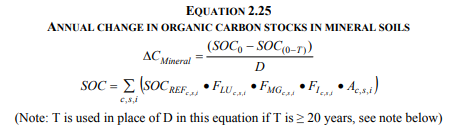
<br>

With: <br>
**SOCRef**: The reference carbon stock under a specific IPCC climate and soil type zone <br>
**FLU** : Stock change factor for land-use systems or sub-system for a particular land-use, dimensionless <br>
**FMG**: Stock change factor for management regime, dimensionless <br>
**FI**: Stock change factor for input of organic matter, dimensionless <br>
**D**: Time dependence of stock change factors which is the default time period for transition between equilibrium SOC values (usely 20 yrs) <br>

### Define input folders and reference data

In [4]:
# the location of the basefolder in which all the input data needed for the simulation is provided

Basefolder = dir_signature

Basefolder_input_data = os.path.join(Basefolder, 'input')

### the basefolder in which all the output results will be stored
#!!!!!! Should be changed once know central location for data access
Basefolder_output_data =  os.path.join(Basefolder, 'output')

### the folder which provided the look-up-tables for converting the IPCC layers to stock change factors
### or a SOCref, this information is needed if not other high resolution data is available on SOC 
SOC_LUT_folder = os.path.join(Basefolder_input_data, 'SOC_LUT')

## the directory of the IPCC climate & soil raster that will be needed for the SOC scenarios and SOC ref calculation
IPCC_climate_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'climate', 'ipcc_climate_zone_100m_EPSG3035_EEA39.tif') 
IPCC_soil_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'soil', 'ipcc_soil_type_100m_EPSG3035_EEA39.tif') 

## location of the CLC map needed to calculate the FLU factor
CLC_ACC_folder = os.path.join(Basefolder_input_data, 'CLC_ACC')
CLC_ACC_layer = os.path.join(CLC_ACC_folder, 'CLC2018ACC_V2018_20.tif')

# location where the stock change factors for NUTS LEVEL3 and LEVEL0 are stored
SOC_NUTS_factors_folder = os.path.join(Basefolder_input_data,'NUTS_LUT_SOC_scenario')

# location with the NUTS LEVEL 0&3 administrative boundaries
NUTS_layer = gpd.read_file(os.path.join(Basefolder_input_data, 'NUTS', 'NUTS_RG_20M_2021_3035.shp'))

## location with the EEA39 extent

EEA_extent_layer = gpd.read_file(os.path.join(Basefolder_input_data, 'AOI', 'EEA39_extent_noDOM.shp'))

## location of the SOCref layer based on the IPCC soil and climate layers and using the LUT
SOCref_layer = os.path.join(Basefolder_output_data, 'SOC_REF', 'SOC_REF_IPCC_climate_soil_100m.tif')


### Scenario definition 

The user will have the flexibility to define different scenarios for **FMG** & **FI** & **FLU**, options listed below:
Below some information on the possibilities:

 ##### FLU (Land Use) Cropland options:
 
1: Longterm cultivated <br>
2: Paddy rice <br>
3: Perrennial/Tree crop <br>
4: Set aside (<20 yrs) <br>
 
##### FMG (Management) Cropland options:

1: Full tillage <br>
2: Reduced <br>
3: No-till <br>

##### FI (Input) Cropland options:

1: Low <br>
2: Medium <br>
3: High without manure <br>
4: High with manure <br>

##### FLU (Land use) Grassland options:

5: All grassland <br>

##### FMG (Management) Grassland options:

1: Nominally managed <br>
2: Moderately degraded <br>
3: Severely degraded <br>
4: Improved grassland <br>


##### FI (Input) Grassland options:

1: Nominal <br>
2: High <br>

<br>

The original IPCC document in which all these options are defined, can be consulted here:
* Cropland : https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_05_Ch5_Cropland.pdf
* Grassland: https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_06_Ch6_Grassland.pdf

<br>

<br> The use of **NUTS specific** factors can be enabled by setting the parameter **'run_NUTS_specific_scenario' on True**.
<br> In that case the stock change factos defined in the folder data folder 'NUTS_LUT_SOC_scenario' will be loaded. 

**Options to run SOC scenario's:

**Option 1**: Run with NUTS specific stock change factors (set  **'run_NUTS_specific_scenario'** to True):

    Decision tree to select stock change factors if
    1. load NUTS3 factors and check if factors are available for NUTS region
    2. if step 1 could not be completed check if for the NUTS0 region some factors are defined
    3. if step 2 is also not compled use the default factors for that NUTS3 region (speficied by the 'dict_stock_change_factors' parameter, specified below)
    
   
**Option 2**: Run 'default' scenario by applying some stock change factors for all NUTS regions:
    Specify in the 'dict_stock_change_factor' parameter the scenario that should be run, below an overiew of some agreed **reference scenario's for cropland** as defined by ETC:
    
    Scenario_1_baseline (Cropland):  FLU: 1 FI: 1 FMG: 1
    Scenario_1_future (Cropland): FLU: 1 FI: 3 FMG: 3
    Scenario_2_future (Cropland): FLU: 3 FI: 3 FMG: 3
    Scenario_3_future (Cropland): FLU: 4 FI: 3 FMG: 3
    
   
<br>
*Define below the **baseline** scenario per land use category*



In [9]:
#### the scenario settings to define
dict_stock_change_factors = {
    'Cropland': {'FMG': 1, 'FI': 1, 'FLU': 1}}
#'Grassland': {'FMG': 1, 'FI': 1, 'FLU': 5}

# this name will be used in the NUTS stats naming and SOC raster layer so that they can be easily linked to a specific scenario
scenario_name = 'Scenario_1_baseline' 

### Specify area of interest
(running on the entire EEA39 extent is not recommended in a Notebook environment due to memory limitations!) 
NUTS based processing of entire extent is possible, but in that case the **'NUTS_based_processing'** parameter should be set to True (automatic set to True if NUTS specific scenarios are used).

Options for selecting countries are the following ones:
'FR'
'HR'
'HU'
'AL'
'AT'
'BE'
'BG'
'CH'
'CY'
'CZ'
'DE'
'DK'
'EE'
'EL'
'IE'
'ES'
'FI'
'IS'
'PT'
'RO'
'RS'
'SE'
'SI'
'SK'
'TR'
'UK'
'NO'
'IT'
'LI'
'LT'
'LU'
'LV'
'ME'
'MK'
'MT'
'NL'
'PL'

##### Define settings for running SOC scenario

In the cell below the user should define which kind of settings should be used for the processing

In [11]:
#select now the country of interest; if set to None the entire EEA39 extent will be processed
Country = 'BE'

### Define now the way the stock change factors should be defined. If set to false the default (defined in 'dict_stock_change_factors') will be used for all NUTS regions
run_NUTS_specific_scenario =  False

## Define if stats should be derived at NUTS level:
add_stats_NUTS_level = True


if run_NUTS_specific_scenario or add_stats_NUTS_level:
    NUTS_based_processing = True
elif Country is not None:
    NUTS_based_processing = False
else:
    NUTS_based_processing = True
    
    
## In case the baseline is used instead of the current FLU (based on CLC input layer).
## For baseline --> Set to True ('dict_stock_change_factors' input will be used)
## For current --> Set to False
Fixed_factor_FLU = True
        

## dictionary that will define all the flexible parameters that are set by the user
settings = {
    'Country': Country,
    'year_baseline': 2018, # the reference year for the calculation
    'CLC_ACC_folder': CLC_ACC_folder,
    'Basefolder_input_data': Basefolder_input_data ,
    'Basefolder_output': Basefolder_output_data,
    'SOC_LUT_folder': SOC_LUT_folder,
    'SOC_NUTS_factors_folder': SOC_NUTS_factors_folder,
    'path_IPCC_climate_resampled': IPCC_climate_raster,
    'path_IPCC_soil_resampled': IPCC_soil_raster,
    'NUTS_extent_map': NUTS_layer,
    'EEA_extent_map': EEA_extent_layer,
    'Stock_change_scenario': dict_stock_change_factors, # the settings to create the stock change factors
    'Scaling': 100, # the factors of the IPCC LUT are multiplied by 100 to save memory ,
    'Scenario_name': scenario_name,
    'run_NUTS_specific_scenario': run_NUTS_specific_scenario,
    'block_based_processing': NUTS_based_processing,
    'add_stats_NUTS_level': add_stats_NUTS_level,
    'Fixed_factor_FMG': True,
    'Fixed_factor_FI': True,
    'Fixed_factor_FLU': Fixed_factor_FLU,
    'overwrite': False,
    'commit_id': '3eb0ca6b2b945125f5eab2fc211b6c3d3f390299' #way to link the output maps with a certain version of the code. The commit ID will be written in the metadata of the maps
}

pprint.pprint(settings)

{'Basefolder_input_data': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input',
 'Basefolder_output': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\output',
 'CLC_ACC_folder': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\CLC_ACC',
 'Country': 'BE',
 'EEA_extent_map':                                            PopupInfo  Shape_Leng  Shape_Area  \
0  TILE PROPERTIES<br><table border=0 cellpadding...    4.522357    1.258132   

   Orign   Tile                                           geometry  
0  EEA39  25SFD  MULTIPOLYGON (((2006608.023 1117756.009, 21078...  ,
 'Fixed_factor_FI': True,
 'Fixed_factor_FLU': True,
 'Fixed_factor_FMG': True,
 'NUTS_extent_map':      NUTS_ID  LEVL_CODE CNTR_CODE               NAME_LATN  \
0         FR          0        FR                  France   
1         HR          0        HR                Hrvatska   
2         HU          0        HU           MagyarorszÃ¡g   
3         AL     

 **FOR NUTS SPECIFIC PROCESSING ALL THE CELLS UNTIL 'SOC calculation' can be skipped**

#### Clipping of reference layers to the desired AOI

In [12]:
if not NUTS_based_processing:
    ### clip the CLC ACC layer to the country of interest
    mask_raster_extent([CLC_ACC_layer], gpd.read_file(NUTS_layer)
                               , Path(CLC_ACC_layer).parent,settings,
                               overwrite=False, Country_clipping=True)

    ### Clip the SOCref to the proper extent
    mask_raster_extent([SOCref_layer], gpd.read_file(NUTS_layer)
                               , Path(SOCref_layer).parent,settings,
                               overwrite=False, Country_clipping=True)

    ## Clipping of the IPCC climate layer
    mask_raster_extent([IPCC_climate_raster], gpd.read_file(NUTS_layer)
                               , Path(IPCC_climate_raster).parent,settings,
                               overwrite=False, Country_clipping=True)

    settings.update({'path_IPCC_climate_resampled': Path(glob.glob(os.path.join((Path(IPCC_climate_raster).parent).as_posix(),Country, '*.tif'))[0])})


#### FLU generation (stock change factor)

In [13]:
###### FLU LAYER GENERATION
if not NUTS_based_processing:
    create_FLU_layer(SOC_LUT_folder,settings)


#### FMG generation (stock change factor)

In [14]:
###### FMG LAYER GENERATION
if not NUTS_based_processing:
    create_factor_layer(settings, type_factor='FMG'
                    ,fixed_factor_creation=settings.get('Fixed_factor_FMG'))


#### FI generation (stock change factor)

In [15]:
#### FI LAYER GENERATION
if not NUTS_based_processing:
    create_factor_layer(settings, type_factor='FI'
                    ,fixed_factor_creation=settings.get('Fixed_factor_FI'))

## SOC calculation 
The final SOC calculation under the defined scenario

**Unit**: tonnes C/pixel

In [9]:
### NOW THE FINAL SOC BASED ON THE DEFINED SCENARIO CAN BE CALCULATED
if not NUTS_based_processing:
    create_SOC_scenario_layer(settings)
else:
    SOC_strat_IPCC_block_proc(settings)

2022-12-15 13:38:09.006 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE100 
0.0% COMPLETED
2022-12-15 13:38:09.168 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE211 
2.27% COMPLETED
2022-12-15 13:38:09.301 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE212 
4.55% COMPLETED
2022-12-15 13:38:09.380 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE213 
6.82% COMPLETED
2022-12-15 13:38:09.535 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE224 
9.09% COMPLETED
2022-12-15 13:38:09.679 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR NUTS3 REGION: BE225 
11.36% COMPLETED
2022-12-15 13:38:09.784 | INFO     | SOC.SOC_stratification:SOC_strat_IPCC_block_proc:51 - CALCULATING SOC FOR N

## Visualize result

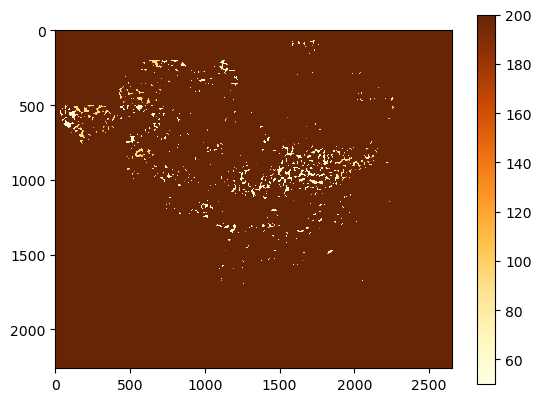

In [17]:
if Country != None:
    dir_SOC_scenario = os.path.join(Basefolder_output_data, 'SOC_scenario', Country,'SOC_{}_{}.tif'.format(scenario_name, Country))
else:
    dir_SOC_scenario = os.path.join(Basefolder_output_data, 'SOC_scenario','SOC_{}_{}.tif'.format(scenario_name, 'EEA39'))
    
SOC_outcome_array = rasterio.open(dir_SOC_scenario).read(1)

plt.imshow(SOC_outcome_array, cmap=plt.get_cmap('YlOrBr'),
               vmin=50, vmax=200)
plt.colorbar()

## Show some aggregated stats

In [18]:
## Open the file with the stats for the aggregated SOC per NUTS region
outdir_SOC_stats = os.path.join(settings.get('Basefolder_output'),'SOC_NUTS_stats',settings.get('Country'))
outname = f'SOC_stats_NUTS_{settings.get("Country")}_{settings.get("Scenario_name")}.shp'
print(gpd.read_file(os.path.join(outdir_SOC_stats, outname)))

    FI_factor FI_src  FLU_factor FLU_src  FMG_factor FMG_src  IPCC_cat  \
0         1.0   None         1.0   EEA39         1.0    None  Cropland   
1         1.0   None         1.0   EEA39         1.0    None  Cropland   
2         1.0   None         1.0   EEA39         1.0    None  Cropland   
3         1.0   None         1.0   EEA39         1.0    None  Cropland   
4         1.0   None         1.0   EEA39         1.0    None  Cropland   
5         1.0   None         1.0   EEA39         1.0    None  Cropland   
6         1.0   None         1.0   EEA39         1.0    None  Cropland   
7         1.0   None         1.0   EEA39         1.0    None  Cropland   
8         1.0   None         1.0   EEA39         1.0    None  Cropland   
9         1.0   None         1.0   EEA39         1.0    None  Cropland   
10        1.0   None         1.0   EEA39         1.0    None  Cropland   
11        1.0   None         1.0   EEA39         1.0    None  Cropland   
12        1.0   None         1.0   EEA